<a href="https://colab.research.google.com/github/kurkur19/Neural_networks_Al_Khmuz_BS_25/blob/main/DKR_NN_Al_Khmuz_BS_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ДОМАШНЯ КОНТРОЛЬНА РОБОТА: НЕЙРОННОЇ МЕРЕЖІ

Виконала студентка групи БС-25 Аль Хмуз Карина Бассамівна (1 варіант)

##*Практична частина*

Імпортуємо основні бібліотеки

In [40]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Завантаження Kaggle API Key

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karinaalkhmuz","key":"13f1cac7d172b3efc432e39574f6a61d"}'}

Налаштування Kaggle

In [9]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Завантаження датасету


In [11]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p ./brain_mri_dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 99% 15.0M/15.1M [00:01<00:00, 23.5MB/s]
100% 15.1M/15.1M [00:01<00:00, 15.2MB/s]


Перевірка змісту папки

In [12]:
print("Зміст папки з даними:")
!ls brain_mri_dataset

Зміст папки з даними:
brain_tumor_dataset  no  yes


Датасет завантажено, і тепер ми можемо перейти до аналізу структури даних. Переглянемо вміст папок no та yes, щоб зрозуміти кількість зображень у кожній категорії та підготуємо попередній огляд датасету.

Підрахунок кількості зображень у кожній категорії

In [14]:
categories = ["no", "yes"]
data_path = "./brain_mri_dataset/brain_tumor_dataset"

for category in categories:
    folder_path = os.path.join(data_path, category)
    num_images = len(os.listdir(folder_path))
    print(f"Кількість зображень у категорії '{category}': {num_images}")


Кількість зображень у категорії 'no': 98
Кількість зображень у категорії 'yes': 155


Чудово, у нас є два класи:

- 'no' (без пухлини): 98 зображень,
- 'yes' (з пухлиною): 155 зображень.

Датасет трохи незбалансований, оскільки кількість зображень у класі "yes" більша, ніж у класі "no". Це слід врахувати під час навчання моделі.

In [16]:
# Візуалізація прикладів
def show_examples(data_path, category, num_examples=4):
    folder_path = os.path.join(data_path, category)
    images = os.listdir(folder_path)[:num_examples]

    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{category}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Приклади з категорій "no" та "yes"

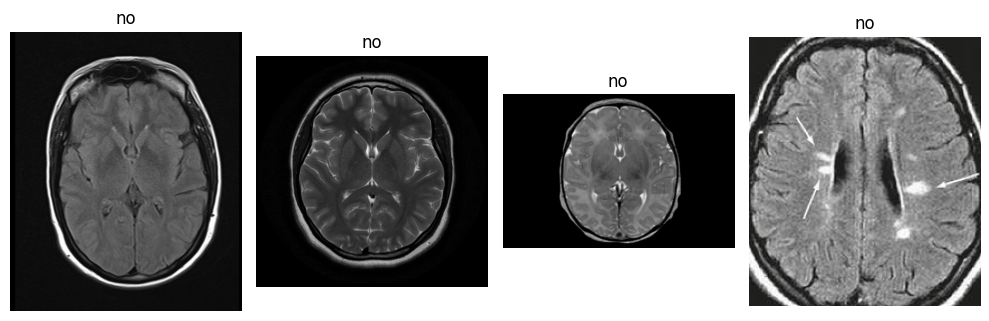

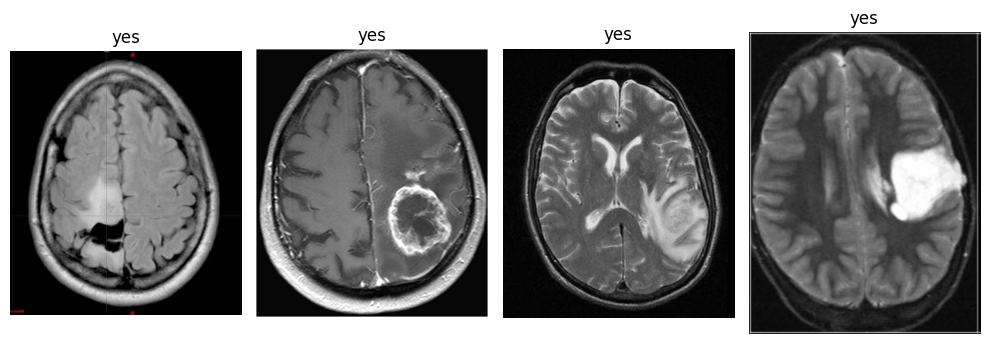

In [17]:
show_examples(data_path, "no")
show_examples(data_path, "yes")

**Попередній аналіз зображень**

Датасет "Brain MRI Images for Brain Tumor Detection" містить зображення магнітно-резонансної томографії (МРТ) мозку, які розділені на два класи:

- "No" (без пухлини): 98 зображень.
- "Yes" (з пухлиною): 155 зображень.

Приклади зображень показують високу якість та чіткість деталей, що дозволяє легко розрізняти патерни, пов'язані з наявністю або відсутністю пухлини. Зображення в класі "Yes" демонструють помітні аномалії, які можуть слугувати ключовими ознаками для діагностики.

##Попередня обробка даних

In [19]:
# Визначимо розміри зображень і розмір пакету
IMG_SIZE = (150, 150)  # Розмір, до якого будуть масштабовані всі зображення
BATCH_SIZE = 32  # Розмір пакету для навчання

Генератори даних із аугментацією для тренувального набору і без аугментації для тестового

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,        # Нормалізація пікселів (0-1)
    validation_split=0.2,   # Відділимо 20% даних для валідації
    rotation_range=20,      # Обертання зображень на випадкові кути
    width_shift_range=0.2,  # Горизонтальний зсув
    height_shift_range=0.2, # Вертикальний зсув
    shear_range=0.2,        # Зсув
    zoom_range=0.2,         # Збільшення/зменшення
    horizontal_flip=True    # Віддзеркалення
)

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Лише нормалізація

Створення генераторів для тренувальних, валідаційних та тестових даних

In [21]:
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'  # Вибір тренувальних даних
)

validation_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'  # Вибір валідаційних даних
)

test_generator = test_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


Перевіримо класи

In [22]:
print("Класи:", train_generator.class_indices)

Класи: {'no': 0, 'yes': 1}



Дані підготовлені та розділені на:

- Тренувальний набір: 203 зображення.
- Валідаційний набір: 50 зображень.
- Тестовий набір: 253 зображення.

**Класи позначено так:**

- 'no': 0
- 'yes': 1

##Статистичний аналіз датасету

Ми вже зробили базовий аналіз (кількість зображень у кожному класі) та візуалізували приклади. Давайте також побудуємо графік розподілу кількості зображень у класах та оцінемо розміри зображень та їх варіативність.

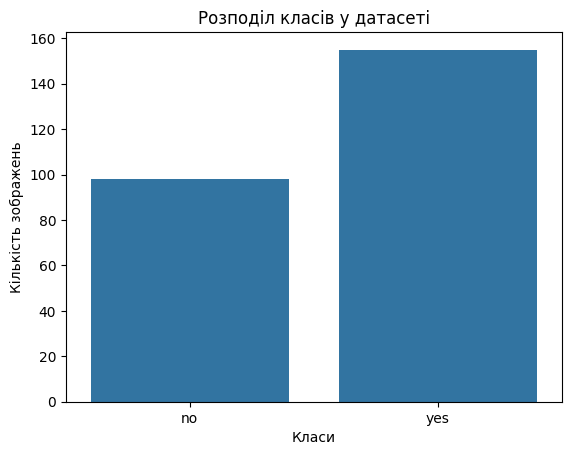

In [24]:
# Розподіл класів
class_counts = {'no': 98, 'yes': 155}
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Розподіл класів у датасеті")
plt.xlabel("Класи")
plt.ylabel("Кількість зображень")
plt.show()


Ми бачимо, що класи трохи незбалансовані, і це може вплинути на навчання моделі. У звіті можна зазначити, що дані для класу "Yes" (з пухлиною) представлені більшою кількістю зображень, ніж для класу "No" (без пухлини).

##Побудова нейронної мережі

Переходимо до побудови нейронної мережі. Створимо просту модель для бінарної класифікації, використовуючи TensorFlow/Keras.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Побудова моделі

In [26]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Бінарна класифікація
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Компіляція моделі


In [27]:
model.compile(
    optimizer='adam',  # Оптимізатор
    loss='binary_crossentropy',  # Функція втрат
    metrics=['accuracy']  # Метрика для оцінки точності
)

Огляд архітектури моделі

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

**Вибір архітектури моделі**

Для задачі бінарної класифікації обрано згорткову нейронну мережу з наступною архітектурою:

- 3 згорткових шари для витягнення просторових ознак із зображень, кожен із яких супроводжується шаром максимального пулінгу для зменшення розмірності.
- 1 прихований повнозв'язний шар із 128 нейронами та функцією активації ReLU для високорівневого представлення даних.
- Вихідний шар із одним нейроном та функцією активації sigmoid для бінарної класифікації.
- Dropout шар із ймовірністю 0.5 для запобігання перенавчанню.

##Навчання моделі

In [31]:
# Навчання моделі
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6010 - loss: 0.6713 - val_accuracy: 0.6400 - val_loss: 0.5890
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6831 - loss: 0.6040 - val_accuracy: 0.7200 - val_loss: 0.5691
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6632 - loss: 0.6210 - val_accuracy: 0.7200 - val_loss: 0.5000
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7339 - loss: 0.5983 - val_accuracy: 0.7200 - val_loss: 0.5704
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6883 - loss: 0.6587 - val_accuracy: 0.7000 - val_loss: 0.5800
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7454 - loss: 0.5808 - val_accuracy: 0.7400 - val_loss: 0.5462
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7182 - loss: 0.5867 - val_accuracy: 0.6800 - val_loss: 0.6453
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6540 - loss: 0.6490 - val_accuracy: 0.7600 - val_loss: 0.5336
Epoch 9/

In [32]:
# Збереження моделі
model.save("brain_tumor_classifier.h5")
print("Модель успішно збережена!")

Модель успішно збережена!


Модель успішно пройшла 10 епох навчання. Ось що можна сказати про результати:

- Точність (accuracy) на тренувальному наборі зросла до ~78%, а на валідаційному наборі до ~76%.
- Втрати (loss) поступово зменшувались, що свідчить про навчання моделі, але є деякі коливання, які можуть свідчити про необхідність додаткового налаштування.

##Візуалізація графіків точності та втрат

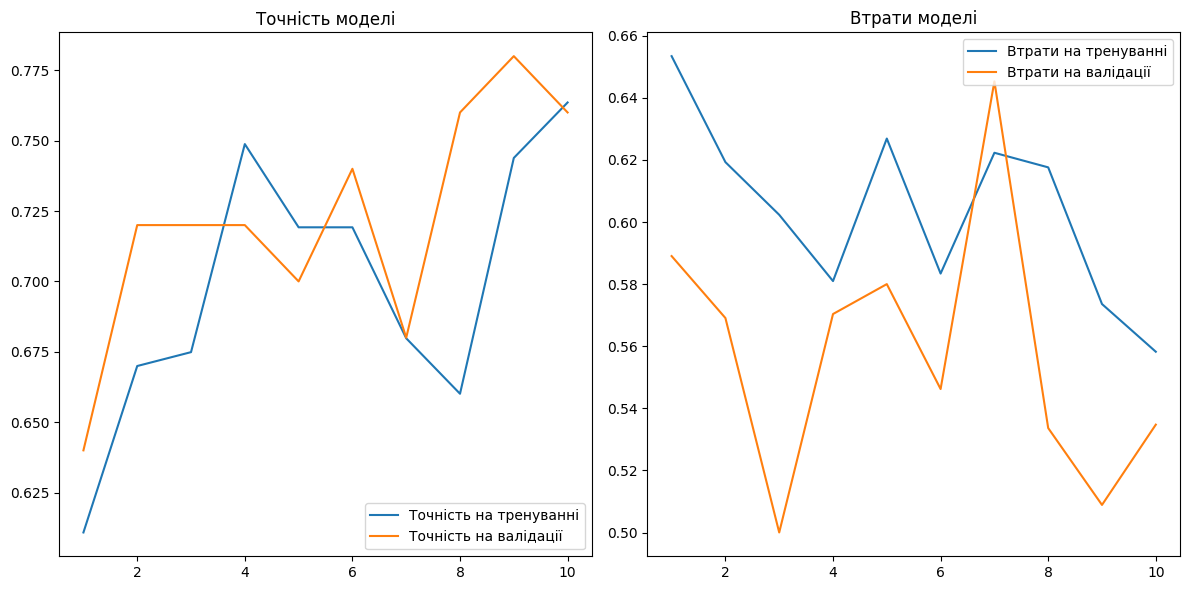

In [38]:
# Графіки точності та втрат
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = list(range(1, len(acc) + 1))  # Створюємо список епох

    # Графік точності
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Точність на тренуванні')
    plt.plot(epochs_range, val_acc, label='Точність на валідації')
    plt.legend(loc='lower right')
    plt.title('Точність моделі')

    # Графік втрат
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Втрати на тренуванні')
    plt.plot(epochs_range, val_loss, label='Втрати на валідації')
    plt.legend(loc='upper right')
    plt.title('Втрати моделі')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


**Аналіз графіків**

**Точність:**

- Спостерігається поступове зростання точності на тренувальному наборі, що свідчить про адаптацію моделі до даних.
- Точність на валідаційному наборі також зростає, що є гарним сигналом, але можливі коливання можуть вказувати на перенавчання або недостатню кількість даних.

**Втрати:**

- Втрати на тренуванні поступово зменшуються, що означає, що модель навчається.
- Втрати на валідації мають коливання, але загалом демонструють зменшення.

##Перевірка моделі на тестовому наборі

In [39]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Точність на тестовому наборі: {test_accuracy * 100:.2f}%")
print(f"Втрати на тестовому наборі: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 514ms/step - accuracy: 0.7993 - loss: 0.4883
Точність на тестовому наборі: 79.05%
Втрати на тестовому наборі: 0.4782



Модель досягла 79.05% точності на тестовому наборі, що свідчить про її здатність класифікувати зображення. Втрати на тестовому наборі також доволі низькі (0.4782), що підтверджує хорошу продуктивність.

Подивимось на передбачення моделі та переглянемо кілька правильно і неправильно класифікованих прикладів.

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/step
Правильно класифіковані приклади:


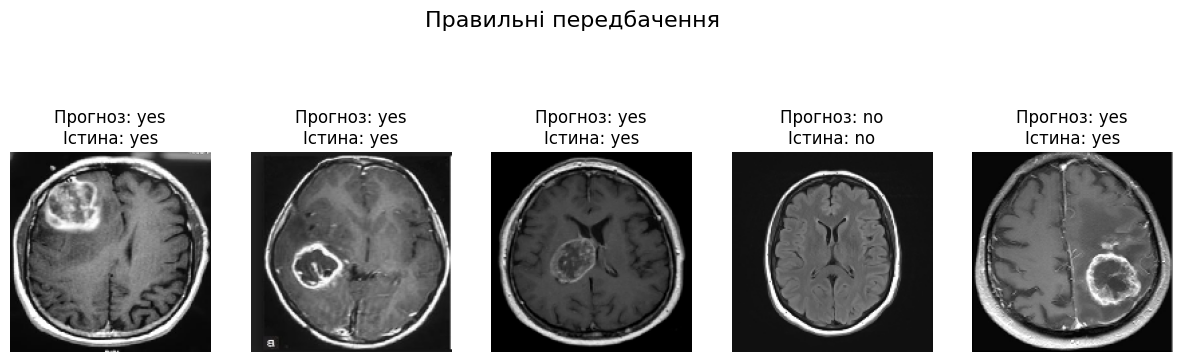

Неправильно класифіковані приклади:


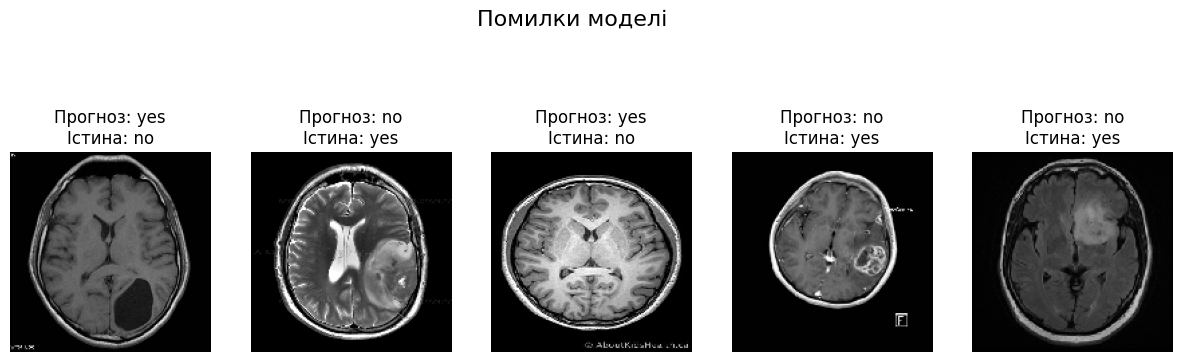

In [48]:
# Отримання всіх зображень, міток та передбачень з тестового набору
test_images, test_labels = [], []
for _ in range(len(test_generator)):
    imgs, labels = next(test_generator)
    test_images.extend(imgs)
    test_labels.extend(labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Отримання передбачень
predictions = model.predict(test_images)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Ідентифікація правильно та неправильно класифікованих зразків
correct_indices = [i for i in range(len(test_labels)) if predicted_classes[i] == test_labels[i]]
error_indices = [i for i in range(len(test_labels)) if predicted_classes[i] != test_labels[i]]

# Функція для візуалізації зображень
def plot_images(images, labels, predictions, indices, title, n_images=5):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[:n_images]):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(images[idx])
        pred_label = class_labels[int(predictions[idx])]
        true_label = class_labels[int(labels[idx])]
        plt.title(f"Прогноз: {pred_label}\nІстина: {true_label}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Відображення правильно класифікованих прикладів
print("Правильно класифіковані приклади:")
plot_images(test_images, test_labels, predicted_classes, correct_indices, "Правильні передбачення")

# Відображення неправильно класифікованих прикладів
print("Неправильно класифіковані приклади:")
plot_images(test_images, test_labels, predicted_classes, error_indices, "Помилки моделі")




На зображенні представлено приклади передбачень моделі для завдання бінарної класифікації зображень МРТ мозку. Верхня частина демонструє правильно класифіковані зразки, де прогноз моделі збігається з реальними мітками. Наприклад, на зображеннях із класом "yes" (наявність пухлини) видно чітко виражені аномалії, які модель правильно ідентифікує.

Нижня частина містить помилки моделі, де передбачення не відповідають істинним класам. Наприклад, у деяких випадках модель прогнозує "yes" (наявність пухлини) для зображень, де насправді пухлина відсутня ("no"). Це може бути пов’язано із схожістю аномальних структур із характерними ознаками пухлини, або ж із обмеженнями самого датасету.